In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math

In [2]:
#data
Aktp_data = np.array([1, 1.57, 2.25, 1.85, 1.85, 0.65])
Agop_data = np.array([1, 1.64, 2.84, 2.91, 2.34, 0.98])
Agopgw_data = np.array([1, 1.26, 1.6, 3.07, 2.33, 1.22])

data_values = np.array([[Aktp_data],
                       [Agop_data],
                       [Agopgw_data]])

In [137]:
#nmda data from Thalhammer et al.

nmda_x = [108.77762801045833-120, 125.66705100930517-120, 147.06140279649867-120, 168.61165694983492-120, 188.7003264205789-120, 208.8734430063173-120, 224.78198028484644-120, 252.21430079412767-120, 266.70672491352275-120, 292.67421277425-120, 308.54702242720464-120, 327.3170177176539-120, 350.40031180473215-120, 369.15731523133604-120,]
nmda_y = [0.2911963882618509, 0.5530474040632054, 0.6839729119638827, 0.7065462753950338, 0.7449209932279908, 0.7246049661399547, 0.6681715575620766, 0.6027088036117381, 0.5304740406320541, 0.4830699774266365, 0.4514672686230248, 0.4063205417607221, 0.3634311512415347, 0.3273137697516928,]
nmda_sem = [0.3702031602708802, 0.6817155756207673, 0.8600451467268622, 0.8893905191873588, 0.9638826185101579, 0.9480812641083518, 0.8781038374717831, 0.8239277652370203, 0.7223476297968396, 0.6681715575620766, 0.6094808126410833, 0.5643340857787809, 0.5079006772009027, 0.46275395033860045]
nmda_sem = np.array(nmda_sem) - np.array(nmda_y)
nmda_x = np.array(nmda_x) / 60

nmda_y = np.array(nmda_y)

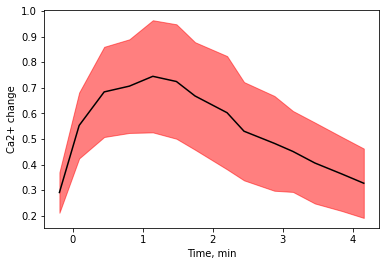

In [113]:
#Check NMDA shape
fig, ax = plt.subplots()

ax.plot(nmda_x,
        nmda_y,
        color = 'black')
ax.fill_between(nmda_x,
                nmda_y - nmda_sem,
                nmda_y + nmda_sem,
                color = 'red',
                alpha = 0.5)

ax.set_xlabel('Time, min')
ax.set_ylabel('Ca2+ change')

plt.show()

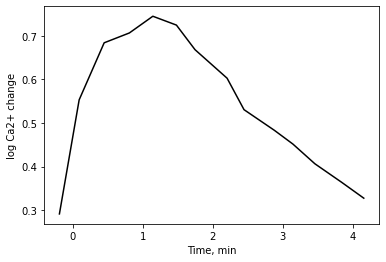

In [114]:
#check if distribution best described by log-normal or gamma
fig, ax = plt.subplots()

ax.plot(nmda_x,
        nmda_y,
        color = 'black')

ax.set_xlabel('Time, min')
ax.set_ylabel('log Ca2+ change')

plt.show()

#>>gamma distribution

In [115]:
#try optimise with scipy.stats.gamma to create 
import scipy.stats as st
from scipy.stats import beta

a, b = 1., 2.
rng = np.random.default_rng()
x = beta.rvs(a, b, size=1000, random_state=rng)
type(x)

numpy.ndarray

In [116]:
a1, loc1, scale1 = st.gamma.fit(nmda_y/np.sum(nmda_y))

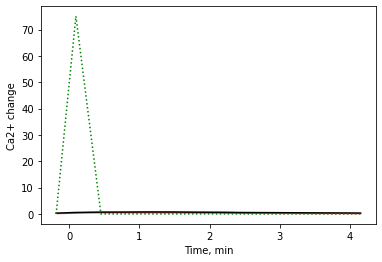

In [117]:
#Check optimisation
fig, ax = plt.subplots()

ax.plot(nmda_x,
        nmda_y,
        color = 'black')

ax.plot(nmda_x,
        st.gamma.pdf(nmda_x, a1, loc = loc1, scale = scale1)*np.sum(nmda_y),
        color = 'green',
        linestyle = ':')

ax.fill_between(nmda_x,
                nmda_y - nmda_sem,
                nmda_y + nmda_sem,
                color = 'red',
                alpha = 0.5)

ax.set_xlabel('Time, min')
ax.set_ylabel('Ca2+ change')

plt.show()

In [118]:
#try optimise with curve_fit to create gamma function
from scipy.optimize import curve_fit

popt, pcov = curve_fit(lambda t, a, loc, scale: st.gamma.pdf(t, a, loc = loc, scale = scale),
                      nmda_x, nmda_y/(np.sum(nmda_y)), maxfev = 1000000000)

popt

array([ 4.10230669e+03, -3.05966032e+02,  7.45357454e-02])

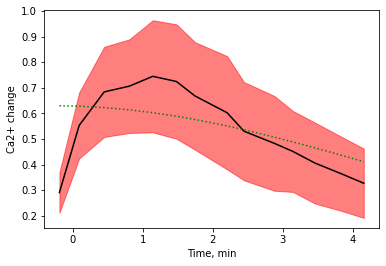

In [119]:
#Check optimisation
fig, ax = plt.subplots()

ax.plot(nmda_x,
        nmda_y,
        color = 'black')

ax.plot(nmda_x,
        st.gamma.pdf(nmda_x, popt[0], loc = popt[1], scale = popt[2])*np.sum(nmda_y),
        color = 'green',
        linestyle = ':')

ax.fill_between(nmda_x,
                nmda_y - nmda_sem,
                nmda_y + nmda_sem,
                color = 'red',
                alpha = 0.5)

ax.set_xlabel('Time, min')
ax.set_ylabel('Ca2+ change')

plt.show()

In [124]:
#try lognormal with curve_fit
def f(x, mu, sigma) :
    return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)- mu)**2)/(2*sigma**2))

popt, pcov = curve_fit(f, nmda_x, nmda_y/np.sum(nmda_y))

pred = f(nmda_x, popt[0], popt[1])

C:\Users\op20001\AppData\Local\Temp/ipykernel_11792/2893290470.py:3: RuntimeWarning: invalid value encountered in log
  return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)- mu)**2)/(2*sigma**2))


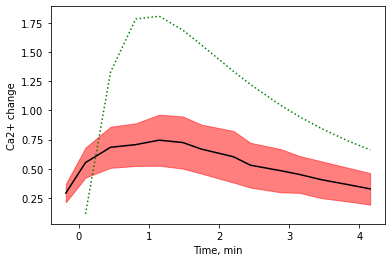

In [129]:
#Check optimisation
fig, ax = plt.subplots()

ax.plot(nmda_x,
        nmda_y,
        color = 'black')

ax.plot(nmda_x,
        pred*np.sum(nmda_y),
        color = 'green',
        linestyle = ':')

ax.fill_between(nmda_x,
                nmda_y - nmda_sem,
                nmda_y + nmda_sem,
                color = 'red',
                alpha = 0.5)

ax.set_xlabel('Time, min')
ax.set_ylabel('Ca2+ change')

plt.show()

In [138]:
#try gaussian
def gauss(x, amp, centre, sigma):
    return amp*np.exp(-(x - centre)**2 / (2*sigma)**2) 

popt, pcov = curve_fit(gauss, nmda_x, nmda_y)
amp, centre, sigma = popt
pred = gauss(nmda_x, amp, centre, sigma)

In [142]:
amp, centre, sigma

(0.6969641043116005, 1.4904524578404597, 1.3102271681828053)

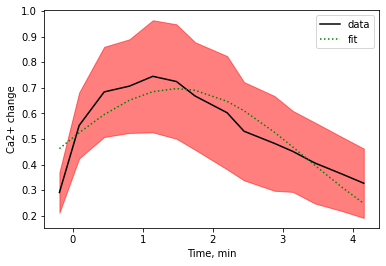

In [148]:
#Check optimisation
fig, ax = plt.subplots()

ax.plot(nmda_x,
        nmda_y,
        color = 'black')

ax.plot(nmda_x,
        pred,
        color = 'green',
        linestyle = ':')

ax.fill_between(nmda_x,
                nmda_y - nmda_sem,
                nmda_y + nmda_sem,
                color = 'red',
                alpha = 0.5)

ax.set_xlabel('Time, min')
ax.set_ylabel('Ca2+ change')

l1 = mlines.Line2D([],[], linestyle = '-', color = 'black', label = 'data')
l2 = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'fit')

plt.legend(handles = [l1, l2])

plt.savefig(r'./plots/nmda_curve_fit-gaussian.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [130]:
#optimise separtely?
nmda_x = np.array([0.21591116334677452, 2.231858801596786, 2.831060406492533, 3.3468763298141866, 3.9269286105088312, 4.332914547407249, 4.861395367687287, 5.423210196761836, 5.820077407850206, 6.3770289164927405, 6.893655393219717, 7.451214816916249, 7.809580741251089, 8.44900605888671, 8.806460110640543, 9.287016960830009,])
nmda_y = np.array([0.007639465845306059, 0.006139942045431557, 0.1898316075300408, 0.5569515086425258, 0.6853836957182518, 0.7082007740785021, 0.7436422217268841, 0.7213114754098362, 0.6687470870736998, 0.6062128918519119, 0.5436584327949912, 0.48614966868629583, 0.44864130985430317, 0.40122393564205994, 0.35617743014042835, 0.3287807250400214])
nmda_sem = np.array([0.050315102636325104, 0.03377981316744005, 0.2501570447222838, 0.677521327686478, 0.861233257006221, 0.886583314758151, 0.957243307868447, 0.9500091187258102, 0.884881152606942, 0.8198139779934752, 0.724553689031185, 0.667004397252223, 0.611967821029808, 0.569535350260390, 0.504427647976656, 0.4695333238768771])-nmda_y
x_plot = nmda_x - 2

In [131]:
x_plot

array([-1.78408884,  0.2318588 ,  0.83106041,  1.34687633,  1.92692861,
        2.33291455,  2.86139537,  3.4232102 ,  3.82007741,  4.37702892,
        4.89365539,  5.45121482,  5.80958074,  6.44900606,  6.80646011,
        7.28701696])

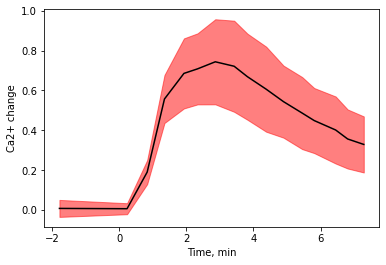

In [99]:
#Check NMDA shape
fig, ax = plt.subplots()

ax.plot(x_plot,
        nmda_y,
        color = 'black')
ax.fill_between(x_plot,
                nmda_y - nmda_sem,
                nmda_y + nmda_sem,
                color = 'red',
                alpha = 0.5)

ax.set_xlabel('Time, min')
ax.set_ylabel('Ca2+ change')

plt.show()

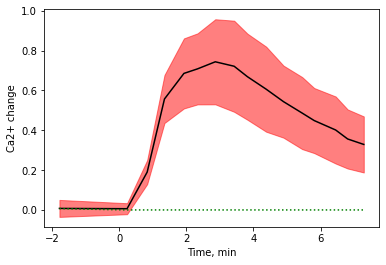

In [100]:
#Check optimisation
a1, loc1, scale1 = st.gamma.fit(nmda_y/np.sum(nmda_y))

fig, ax = plt.subplots()

ax.plot(x_plot,
        nmda_y,
        color = 'black')

ax.plot(x_plot,
        st.gamma.pdf(nmda_x, a1, loc = loc1, scale = scale1)*np.sum(nmda_y),
        color = 'green',
        linestyle = ':')

ax.fill_between(x_plot,
                nmda_y - nmda_sem,
                nmda_y + nmda_sem,
                color = 'red',
                alpha = 0.5)

ax.set_xlabel('Time, min')
ax.set_ylabel('Ca2+ change')

plt.show()

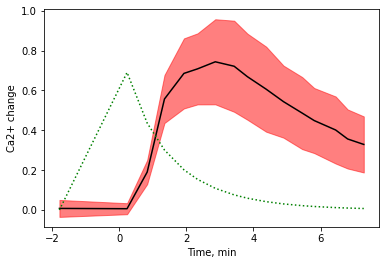

In [101]:
#Check optimisation

popt, pcov = curve_fit(lambda t, a, loc, scale: st.gamma.pdf(t, a, loc = loc, scale = scale),
                      nmda_x, nmda_y/np.sum(nmda_y))
fig, ax = plt.subplots()

ax.plot(x_plot,
        nmda_y,
        color = 'black')

ax.plot(x_plot,
        st.gamma.pdf(nmda_x, popt[0], loc = popt[1], scale = popt[2]) * np.sum(nmda_y),
        color = 'green',
        linestyle = ':')

ax.fill_between(x_plot,
                nmda_y - nmda_sem,
                nmda_y + nmda_sem,
                color = 'red',
                alpha = 0.5)

ax.set_xlabel('Time, min')
ax.set_ylabel('Ca2+ change')

plt.show()

In [109]:
#try lognormal with curve_fit
def f(x, mu, sigma) :
    return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)- mu)**2)/(2*sigma**2))

popt, pcov = curve_fit(f, nmda_x, nmda_y/np.sum(nmda_y))

pred = f(nmda_x, popt[0], popt[1])

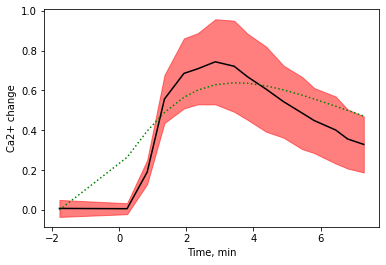

In [110]:
#Check optimisation
fig, ax = plt.subplots()

ax.plot(x_plot,
        nmda_y,
        color = 'black')

ax.plot(x_plot,
        pred*np.sum(nmda_y),
        color = 'green',
        linestyle = ':')

ax.fill_between(x_plot,
                nmda_y - nmda_sem,
                nmda_y + nmda_sem,
                color = 'red',
                alpha = 0.5)

ax.set_xlabel('Time, min')
ax.set_ylabel('Ca2+ change')

plt.show()

In [77]:
np.sum(nmda_y)

7.45869217208049

In [133]:
#try gaussian
def gauss(x, amp, centre, sigma):
    return amp*np.exp(-(x - centre)**2 / (2*sigma)**2) 

popt, pcov = curve_fit(gauss, nmda_x, nmda_y)
amp, centre, sigma = popt
pred = gauss(nmda_x, amp, centre, sigma)

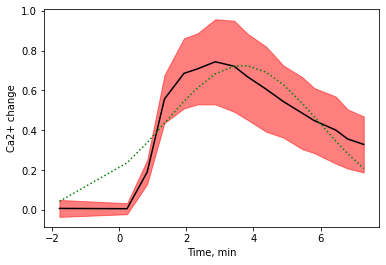

In [136]:
#Check optimisation
fig, ax = plt.subplots()

ax.plot(x_plot,
        nmda_y,
        color = 'black')

ax.plot(x_plot,
        pred,
        color = 'green',
        linestyle = ':')

ax.fill_between(x_plot,
                nmda_y - nmda_sem,
                nmda_y + nmda_sem,
                color = 'red',
                alpha = 0.5)

ax.set_xlabel('Time, min')
ax.set_ylabel('Ca2+ change')

plt.show()